In [14]:
import pandas as pd

# Load the dataset from Google Drive into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/sample_complaints_2years_005.csv')

In [15]:
# Display the first few rows of the DataFrame to understand the data structure
df.head()

,consumer_complaint_narrative,product,sub_product
0,using bread previously known cd supposed matur...,CheckingSavings,cdCertificateOfDeposit
1,presented holder huntington bank mi opened set...,CheckingSavings,cdCertificateOfDeposit
2,complaint nexbank bank employee purposely foll...,CheckingSavings,cdCertificateOfDeposit
3,chase bank month lock cd equal coming maturity...,CheckingSavings,cdCertificateOfDeposit
4,since synchrony bank giving runaround giving a...,CheckingSavings,cdCertificateOfDeposit


In [16]:
# Display the shape of the DataFrame (number of rows and columns)
df.shape

(161446, 3)

In [17]:
# Get the counts of each unique value in the 'product' column
product_sample_counts = df['product'].value_counts()

# Display the product counts
display(product_sample_counts)

,count
product,
CreditReporting,119345
DebtCollection,12784
CheckingSavings,6841
MoneyTransfer,6603
CreditCard,6587
CreditReportingRepair,2594
Mortgage,2350
StudentLoan,1860
VehicleLoanLease,1519


In [18]:
# Create a new column 'hierarchical_label' by combining 'product' and 'sub_product'
# This creates a single label representing the hierarchical classification
df['hierarchical_label'] = df['product'] + '::' + df['sub_product'].fillna('None') # Fill NaN sub_products with 'None'

# Display the first few hierarchical labels to verify the new column
display(df['hierarchical_label'].head())

# Get the unique hierarchical labels to see the different categories
unique_hierarchical_labels = df['hierarchical_label'].unique()
print("\nNumber of unique hierarchical labels:", len(unique_hierarchical_labels))

,hierarchical_label
0,CheckingSavings::cdCertificateOfDeposit
1,CheckingSavings::cdCertificateOfDeposit
2,CheckingSavings::cdCertificateOfDeposit
3,CheckingSavings::cdCertificateOfDeposit
4,CheckingSavings::cdCertificateOfDeposit



Number of unique hierarchical labels: 53


### Evaluation Metrics: Hierarchical Precision, Hierarchical Recall, Hierarchical F1-score

To evaluate the hierarchical multi-class text classification model developed for categorizing consumer complaints into financial products and sub-products, a two-level hierarchical evaluation framework was implemented. The dataset contains a primary categorical label (“product”) and a secondary categorical label (“sub_product”), representing a parent–child relationship. To capture this hierarchical structure, a combined label (“hierarchical_label”) was constructed by concatenating the product and sub-product fields. The evaluation was conducted at both levels of the hierarchy using weighted precision, recall, and F1-scores to account for class imbalance. Specifically, metrics were first computed independently for the product level and the sub-product level, where sub-product metrics were calculated only for valid non-null sub-product instances. Finally, hierarchical precision, recall, and F1-score were derived by averaging the scores from both levels, ensuring that the evaluation reflected both the model’s ability to correctly classify broad product categories and its precision in identifying corresponding sub-products. This approach provided a balanced and interpretable assessment of the model’s performance in capturing hierarchical relationships among financial complaint categories.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to split hierarchical labels into product and sub-product
def split_hierarchical_label(label):
    if '::' in label:
        return label.split('::')
    else:
        return [label, 'None'] # Handle cases with no sub-product

# Function to calculate hierarchical metrics
def hierarchical_metrics(y_true, y_pred):
    product_true = [split_hierarchical_label(label)[0] for label in y_true]
    sub_product_true = [split_hierarchical_label(label)[1] for label in y_true]
    product_pred = [split_hierarchical_label(label)[0] for label in y_pred]
    sub_product_pred = [split_hierarchical_label(label)[1] for label in y_pred]

    # Calculate metrics at the product level
    product_precision = precision_score(product_true, product_pred, average='weighted', zero_division=0)
    product_recall = recall_score(product_true, product_pred, average='weighted', zero_division=0)
    product_f1 = f1_score(product_true, product_pred, average='weighted', zero_division=0)

    # Calculate metrics at the sub-product level (only for non-None sub-products)
    # We need to filter for cases where both true and predicted sub-products are not 'None'
    valid_sub_product_true = [sub for i, sub in enumerate(sub_product_true) if sub != 'None' and sub_product_pred[i] != 'None']
    valid_sub_product_pred = [sub for i, sub in enumerate(sub_product_pred) if sub != 'None' and sub_product_true[i] != 'None']


    sub_product_precision = precision_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_recall = recall_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_f1 = f1_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0


    # A simple way to combine scores (can be weighted based on importance)
    # Here, we'll just average them
    hierarchical_precision = (product_precision + sub_product_precision) / 2
    hierarchical_recall = (product_recall + sub_product_recall) / 2
    hierarchical_f1 = (product_f1 + sub_product_f1) / 2

    return {
        'product_precision': product_precision,
        'product_recall': product_recall,
        'product_f1': product_f1,
        'sub_product_precision': sub_product_precision,
        'sub_product_recall': sub_product_recall,
        'sub_product_f1': sub_product_f1,
        'hierarchical_precision': hierarchical_precision,
        'hierarchical_recall': hierarchical_recall,
        'hierarchical_f1': hierarchical_f1
    }


# Task
Build and evaluate a deep learning model using LSTM for hierarchical multi-class text classification of financial products and sub-products based on consumer complaint narratives. The model should be evaluated using hierarchical precision, recall, and F1-score.

## Data preprocessing

### Subtask:
Clean and tokenize the text data in the `consumer_complaint_narrative` column. Encode the hierarchical labels (`hierarchical_label`) for the model. Split the data into training and testing sets. Pad sequences to ensure uniform input length for the LSTM.


**Reasoning**:
Handle missing values, perform basic text cleaning, tokenize the text data, convert to sequences, encode hierarchical labels, split data, and pad sequences as per the instructions.



In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

# 1. Handle missing values
df['consumer_complaint_narrative'].fillna('', inplace=True)

# 2. Perform basic text cleaning
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove non-alphanumeric characters
    return text

df['cleaned_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)

# 3. Tokenize the cleaned text data
# Set the maximum number of words to keep based on frequency
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_narrative'])

# 4. Convert the tokenized text into sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_narrative'])

# 5. Encode the hierarchical_label column
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['hierarchical_label'])

# 6. Split the preprocessed data
X_train, X_test, y_train, y_test = train_test_split(sequences, encoded_labels, test_size=0.2, random_state=42)

# 7. Pad the sequences
# Determine an appropriate max sequence length (e.g., based on the average or a common percentile)
# Let's check the distribution of sequence lengths
sequence_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 90)) # Use 90th percentile as max length

X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

print("Shape of X_train_padded:", X_train_padded.shape)
print("Shape of X_test_padded:", X_test_padded.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\nMax sequence length used for padding:", max_sequence_length)
print("Number of unique hierarchical labels (after encoding):", len(label_encoder.classes_))

/tmp/ipython-input-885186258.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['consumer_complaint_narrative'].fillna('', inplace=True)


Shape of X_train_padded: (129156, 162)
Shape of X_test_padded: (32290, 162)
Shape of y_train: (129156,)
Shape of y_test: (32290,)

Max sequence length used for padding: 162
Number of unique hierarchical labels (after encoding): 53


## Build the lstm model

### Subtask:
Define an LSTM model architecture suitable for hierarchical text classification. Consider using separate output layers for product and sub-product or a single output layer with the combined hierarchical label.


**Reasoning**:
Import necessary libraries and define the LSTM model architecture as instructed.



In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 2. Define the number of unique hierarchical labels
num_hierarchical_labels = len(df['hierarchical_label'].unique())

# 3. Create a Sequential model
model = Sequential()

# 4. Add an Embedding layer
embedding_dim = 128
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# 5. Add an LSTM layer
lstm_units = 64
model.add(LSTM(lstm_units))

# 6. Add a Dense layer for output
model.add(Dense(num_hierarchical_labels, activation='softmax'))

# 7. Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 8. Display the model summary
model.build(input_shape=(None, max_sequence_length))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 162, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,853 (5.08 MB)

 Trainable params: 1,332,853 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

### Subtask:
Compile the model with an appropriate loss function and optimizer. Train the model on the preprocessed training data.


**Reasoning**:
Fit the compiled model to the padded training data.



In [22]:
from tensorflow.keras.callbacks import EarlyStopping
# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping (to avoid overfitting)
epochs = 10
batch_size = 32
history = model.fit(
    X_train_padded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stop]
)



# 1. Fit the compiled model to the padded training data
#epochs = 10
#batch_size = 32
#history = model.fit(X_train_padded, y_train,
#                      epochs=epochs,
#                      batch_size=batch_size,
#                      validation_split=0.1) # Use 10% of the training data for validation

# 2. Store the training history
# This was already done in the previous step by assigning the output of model.fit to the 'history' variable.

Epoch 1/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.7435 - loss: 1.2782 - val_accuracy: 0.8122 - val_loss: 0.7925
Epoch 2/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8261 - loss: 0.7167 - val_accuracy: 0.8381 - val_loss: 0.6420
Epoch 3/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.8550 - loss: 0.5598 - val_accuracy: 0.8510 - val_loss: 0.5861
Epoch 4/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8675 - loss: 0.4900 - val_accuracy: 0.8535 - val_loss: 0.5738
Epoch 5/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8815 - loss: 0.4330 - val_accuracy: 0.8492 - val_loss: 0.5843
Epoch 6/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.8941 - loss: 0.3823 - val_accuracy: 0.8520 - val_loss: 0.5894


### Hierarchical Evaluation Metrics

In [23]:
# 1. Make predictions on the test set
y_pred_probs = model.predict(X_test_padded)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)

# 2. Decode the predicted labels back to hierarchical labels
y_pred_hierarchical = label_encoder.inverse_transform(y_pred_encoded)

# 3. Decode the true labels back to hierarchical labels for comparison
y_true_hierarchical = label_encoder.inverse_transform(y_test)

# 4. Calculate hierarchical metrics using the defined function
metrics = hierarchical_metrics(y_true_hierarchical, y_pred_hierarchical)

# 5. Display the calculated metrics
print("\nHierarchical Evaluation Metrics:")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

1010/1010 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Hierarchical Evaluation Metrics:
  Product Precision: 0.8798
  Product Recall:    0.8901
  Product F1-score:  0.8771
  Sub-product Precision: 0.8365
  Sub-product Recall:    0.8661
  Sub-product F1-score:  0.8467
  Hierarchical Precision: 0.8581
  Hierarchical Recall:    0.8781
  Hierarchical F1-score:  0.8619


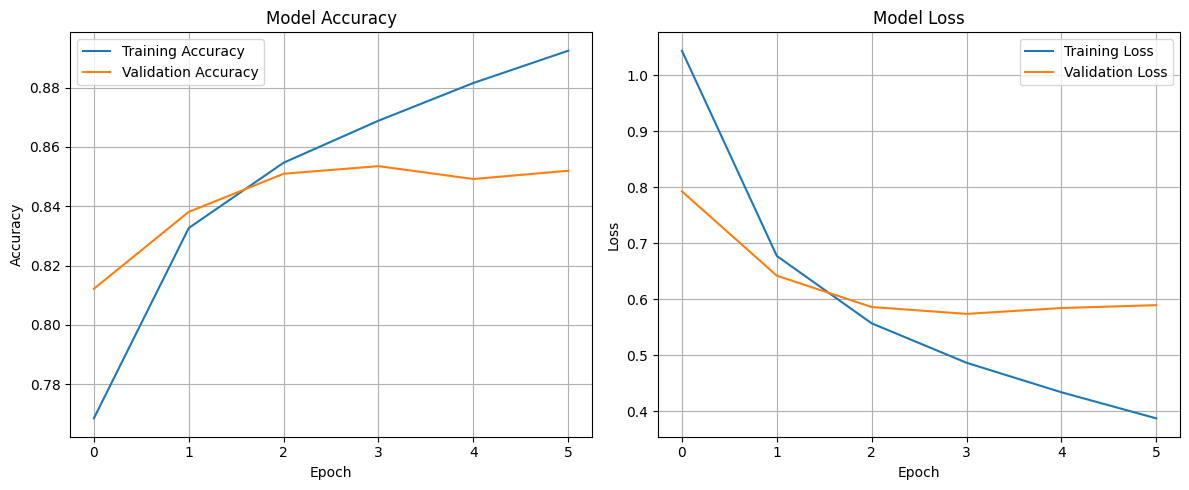

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Build a new model: Bidirectional LSTM

### Subtask:
Define a new LSTM model architecture (Bidirectional LSTM), potentially with different layers, units, or configurations than the previous model.


**Reasoning**:
Import necessary layers and define a new LSTM model architecture with Bidirectional LSTM and Dropout layers as instructed.



In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# 2. Define the number of unique hierarchical labels
# This variable is already defined in a previous cell, but we redefine it here for clarity within this subtask's code block
num_hierarchical_labels = len(df['hierarchical_label'].unique())

# 3. Create a new Sequential model
bi_lstm_model = Sequential()

# 4. Add an Embedding layer
embedding_dim = 256  # Increased embedding dimension
bi_lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# 5. Add a Bidirectional(LSTM()) layer
lstm_units = 128  # Increased LSTM units
bi_lstm_model.add(Bidirectional(LSTM(lstm_units)))

# 6. Add a Dropout layer
dropout_rate = 0.4  # Added Dropout layer
bi_lstm_model.add(Dropout(dropout_rate))

# 7. Add a final Dense layer for output
bi_lstm_model.add(Dense(num_hierarchical_labels, activation='softmax'))

# 8. Display the model summary
bi_lstm_model.build(input_shape=(None, max_sequence_length))
bi_lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 162, 256)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,967,861 (11.32 MB)

 Trainable params: 2,967,861 (11.32 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the new model

### Subtask:
Compile the new model with an appropriate loss function and optimizer.


**Reasoning**:
Compile the new model with the specified loss function, optimizer, and metrics.



In [26]:
# Compile the new model
bi_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary again to see the parameter count after compilation
bi_lstm_model.build(input_shape=(None, max_sequence_length))
bi_lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 162, 256)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,967,861 (11.32 MB)

 Trainable params: 2,967,861 (11.32 MB)

 Non-trainable params: 0 (0.00 B)

## Train the new model

### Subtask:
Train the new model on the preprocessed training data.


**Reasoning**:
Fit the compiled new model to the padded training data as instructed.



In [27]:
from tensorflow.keras.callbacks import EarlyStopping
# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping (to avoid overfitting)
epochs = 10
batch_size = 32
bi_lstm_history = bi_lstm_model.fit(
    X_train_padded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stop]
)


Epoch 1/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 67s 18ms/step - accuracy: 0.8042 - loss: 0.8665 - val_accuracy: 0.8445 - val_loss: 0.6078
Epoch 2/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 65s 18ms/step - accuracy: 0.8514 - loss: 0.5698 - val_accuracy: 0.8494 - val_loss: 0.5706
Epoch 3/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 64s 18ms/step - accuracy: 0.8693 - loss: 0.4842 - val_accuracy: 0.8565 - val_loss: 0.5423
Epoch 4/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 65s 18ms/step - accuracy: 0.8838 - loss: 0.4252 - val_accuracy: 0.8557 - val_loss: 0.5611
Epoch 5/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 64s 18ms/step - accuracy: 0.8966 - loss: 0.3666 - val_accuracy: 0.8551 - val_loss: 0.5762


### Hierarchical Evaluation Metrics

In [28]:
# 1. Make predictions on the test set using the new_model
bi_lstm_y_pred_probs = bi_lstm_model.predict(X_test_padded)
bi_lstm_y_pred_encoded = np.argmax(bi_lstm_y_pred_probs, axis=1)

# 2. Decode the predicted labels back to hierarchical labels
bi_lstm_y_pred_hierarchical = label_encoder.inverse_transform(bi_lstm_y_pred_encoded)

# 3. Decode the true labels back to hierarchical labels for comparison (these are the same as before)
y_true_hierarchical = label_encoder.inverse_transform(y_test) # Already done in previous evaluation

# 4. Calculate hierarchical metrics using the defined function for the new_model
bi_lstm_metrics = hierarchical_metrics(y_true_hierarchical, bi_lstm_y_pred_hierarchical)

# 5. Display the calculated metrics for the new_model
print("\nHierarchical Evaluation Metrics for New Model:")
print(f"  Product Precision: {bi_lstm_metrics['product_precision']:.4f}")
print(f"  Product Recall:    {bi_lstm_metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {bi_lstm_metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {bi_lstm_metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {bi_lstm_metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {bi_lstm_metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {bi_lstm_metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {bi_lstm_metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {bi_lstm_metrics['hierarchical_f1']:.4f}")

1010/1010 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Hierarchical Evaluation Metrics for New Model:
  Product Precision: 0.8867
  Product Recall:    0.8908
  Product F1-score:  0.8772
  Sub-product Precision: 0.8454
  Sub-product Recall:    0.8689
  Sub-product F1-score:  0.8500
  Hierarchical Precision: 0.8661
  Hierarchical Recall:    0.8799
  Hierarchical F1-score:  0.8636


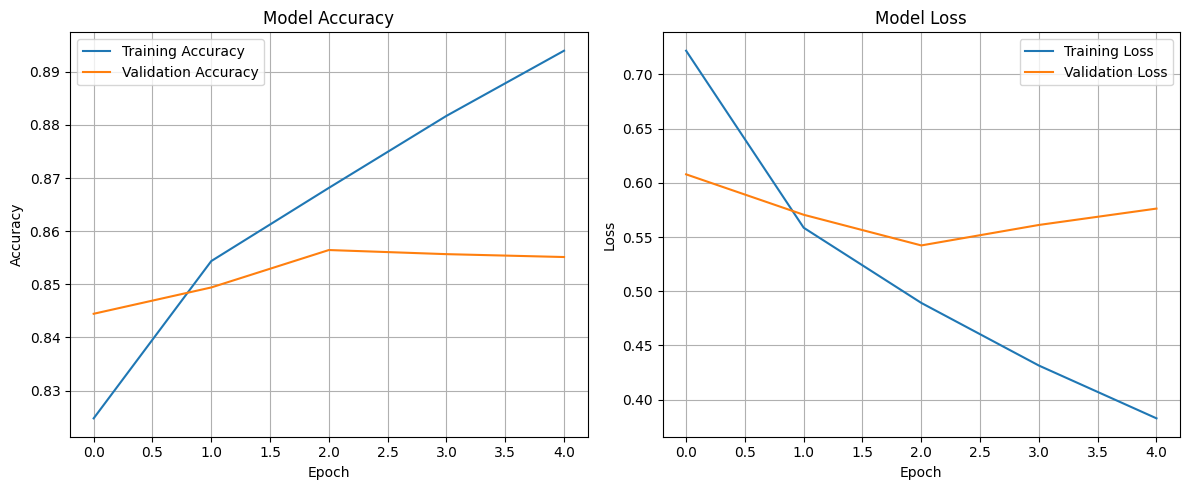

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(bi_lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(bi_lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(bi_lstm_history.history['loss'], label='Training Loss')
plt.plot(bi_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Stacked LSTM with Dense Layers for Hierarchical Text Classification

## Train the new model: Stacked LSTM

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the number of unique hierarchical labels
num_hierarchical_labels = len(df['hierarchical_label'].unique())

# Create the model
model_lstm_stacked = Sequential()

# Embedding layer
embedding_dim = 128
model_lstm_stacked.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# First LSTM layer
model_lstm_stacked.add(LSTM(64, return_sequences=True))
model_lstm_stacked.add(Dropout(0.3))

# Second LSTM layer
model_lstm_stacked.add(LSTM(64))
model_lstm_stacked.add(Dropout(0.3))

# Dense layers for deeper learning
model_lstm_stacked.add(Dense(64, activation='relu'))
model_lstm_stacked.add(Dropout(0.3))
model_lstm_stacked.add(Dense(32, activation='relu'))

# Output layer
model_lstm_stacked.add(Dense(num_hierarchical_labels, activation='softmax'))

# Compile the model
model_lstm_stacked.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model_lstm_stacked.build(input_shape=(None, max_sequence_length))
model_lstm_stacked.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 162, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 162, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 162, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 53)             │         1,749 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,421 (5.23 MB)

 Trainable params: 1,370,421 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

## Stacked LSTM with Dense Layers for Hierarchical Text Classification (with EarlyStopping)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping  (to avoid overfitting)
epochs = 10
batch_size = 32
history_lstm_stacked = model_lstm_stacked.fit(
    X_train_padded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.7407 - loss: 1.2974 - val_accuracy: 0.7882 - val_loss: 0.8677
Epoch 2/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8017 - loss: 0.8041 - val_accuracy: 0.8246 - val_loss: 0.7178
Epoch 3/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - accuracy: 0.8304 - loss: 0.6747 - val_accuracy: 0.8354 - val_loss: 0.6447
Epoch 4/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - accuracy: 0.8447 - loss: 0.6019 - val_accuracy: 0.8406 - val_loss: 0.6231
Epoch 5/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - accuracy: 0.8519 - loss: 0.5561 - val_accuracy: 0.8367 - val_loss: 0.6324
Epoch 6/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - accuracy: 0.8575 - loss: 0.5214 - val_accuracy: 0.8381 - val_loss: 0.6346


### Hierarchical Evaluation Metrics

In [32]:
# 1. Make predictions on the test set using the new_model
stklstm_y_pred_probs = model_lstm_stacked.predict(X_test_padded)
stklstm_y_pred_encoded = np.argmax(stklstm_y_pred_probs, axis=1)

# 2. Decode the predicted labels back to hierarchical labels
stklstm_y_pred_hierarchical = label_encoder.inverse_transform(stklstm_y_pred_encoded)

# 3. Decode the true labels back to hierarchical labels for comparison (these are the same as before)
y_true_hierarchical = label_encoder.inverse_transform(y_test) # Already done in previous evaluation

# 4. Calculate hierarchical metrics using the defined function for the new_model
stklstm_metrics = hierarchical_metrics(y_true_hierarchical, stklstm_y_pred_hierarchical)

# 5. Display the calculated metrics for the new_model
print("\nHierarchical Evaluation Metrics for New Model:")
print(f"  Product Precision: {stklstm_metrics['product_precision']:.4f}")
print(f"  Product Recall:    {stklstm_metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {stklstm_metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {stklstm_metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {stklstm_metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {stklstm_metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {stklstm_metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {stklstm_metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {stklstm_metrics['hierarchical_f1']:.4f}")

1010/1010 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

Hierarchical Evaluation Metrics for New Model:
  Product Precision: 0.8622
  Product Recall:    0.8826
  Product F1-score:  0.8659
  Sub-product Precision: 0.8004
  Sub-product Recall:    0.8540
  Sub-product F1-score:  0.8247
  Hierarchical Precision: 0.8313
  Hierarchical Recall:    0.8683
  Hierarchical F1-score:  0.8453


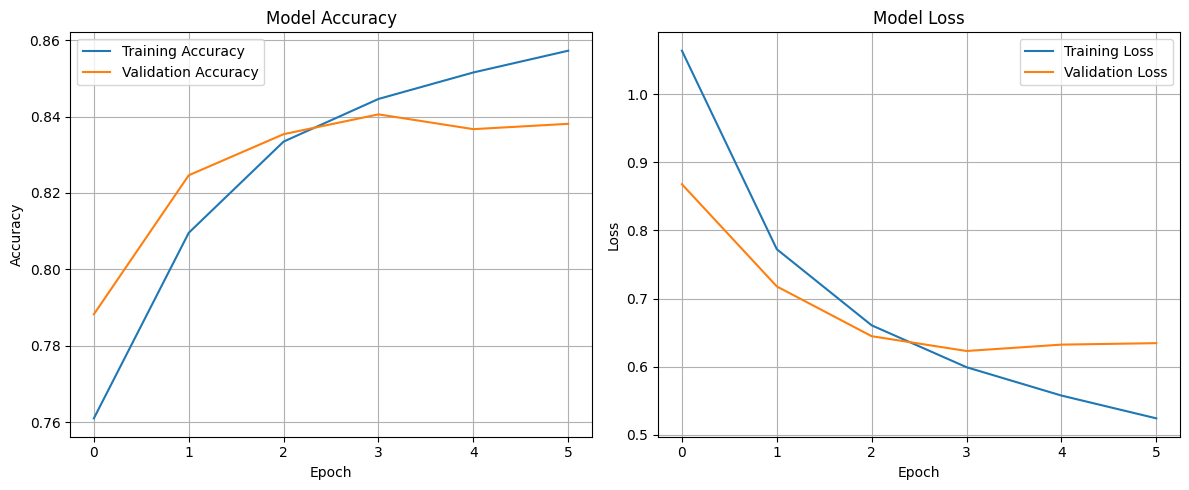

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm_stacked.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm_stacked.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm_stacked.history['loss'], label='Training Loss')
plt.plot(history_lstm_stacked.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# import pandas as pd

# # Create a dictionary to hold the metrics for each model
# metrics_comparison = {
#     'Metric': ['Product Precision', 'Product Recall', 'Product F1-score',
#                'Sub-product Precision', 'Sub-product Recall', 'Sub-product F1-score',
#                'Hierarchical Precision', 'Hierarchical Recall', 'Hierarchical F1-score'],
#     'LSTM Model': [
#         metrics['product_precision'], metrics['product_recall'], metrics['product_f1'],
#         metrics['sub_product_precision'], metrics['sub_product_recall'], metrics['sub_product_f1'],
#         metrics['hierarchical_precision'], metrics['hierarchical_recall'], metrics['hierarchical_f1']
#     ],
#     'Bidirectional LSTM Model': [
#         bi_lstm_metrics['product_precision'], bi_lstm_metrics['product_recall'], bi_lstm_metrics['product_f1'],
#         bi_lstm_metrics['sub_product_precision'], bi_lstm_metrics['sub_product_recall'], bi_lstm_metrics['sub_product_f1'],
#         bi_lstm_metrics['hierarchical_precision'], bi_lstm_metrics['hierarchical_recall'], bi_lstm_metrics['hierarchical_f1']
#     ],
#     'Stacked LSTM Model': [
#         stklstm_metrics['product_precision'], stklstm_metrics['product_recall'], stklstm_metrics['product_f1'],
#         stklstm_metrics['sub_product_precision'], stklstm_metrics['sub_product_recall'], stklstm_metrics['sub_product_f1'],
#         stklstm_metrics['hierarchical_precision'], stklstm_metrics['hierarchical_recall'], stklstm_metrics['hierarchical_f1']
#     ]
# }

# # Create a pandas DataFrame from the dictionary
# metrics_df = pd.DataFrame(metrics_comparison)

# # Display the comparison table
# display(metrics_df)

# Task
Train and evaluate a CNN-1D model for text classification using hierarchical evaluation metrics, ensuring the model does not overfit, and compare its performance to existing models.

## Build cnn-1d model

### Subtask:
Define the architecture for the CNN-1D model including Embedding, Conv1D, MaxPooling1D, Flatten, Dense, and Dropout layers.


**Reasoning**:
Define the architecture for the CNN-1D model as instructed, including Embedding, Conv1D, MaxPooling1D, Flatten, Dense, and Dropout layers, and display the model summary.



In [35]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# 2. Define the number of unique hierarchical labels
# This variable is already defined in previous cells, but we redefine it here for clarity within this subtask's code block
num_hierarchical_labels = len(df['hierarchical_label'].unique())

# 3. Create a new Sequential model for CNN-1D
cnn_model = Sequential()

# 4. Add an Embedding layer
embedding_dim = 128
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# 5. Add a Conv1D layer
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# 6. Add a MaxPooling1D layer
cnn_model.add(MaxPooling1D(pool_size=5))

# 7. Add a Flatten layer
cnn_model.add(Flatten())

# 8. Add a Dense layer
cnn_model.add(Dense(64, activation='relu'))

# 9. Add a Dropout layer
dropout_rate = 0.5
cnn_model.add(Dropout(dropout_rate))

# 10. Add the final Dense output layer
cnn_model.add(Dense(num_hierarchical_labels, activation='softmax'))

# 11. Build the model
cnn_model.build(input_shape=(None, max_sequence_length))

# 12. Display the model summary
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 162, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 158, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       254,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,619,509 (6.18 MB)

 Trainable params: 1,619,509 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

## Compile cnn-1d model

### Subtask:
Compile the CNN-1D model with an appropriate loss function, optimizer, and metrics.


**Reasoning**:
Compile the CNN-1D model with the specified loss function, optimizer, and metrics, then display the model summary.



In [36]:
# Compile the CNN-1D model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary again to verify the compilation
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 162, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 158, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       254,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,619,509 (6.18 MB)

 Trainable params: 1,619,509 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

## Train cnn-1d model

### Subtask:
Train the compiled CNN-1D model on the preprocessed training data using Early Stopping to prevent overfitting.


**Reasoning**:
Import necessary callback and train the compiled CNN-1D model with Early Stopping as instructed.



In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping (to avoid overfitting)
epochs = 10
batch_size = 32
history_cnn = cnn_model.fit(
    X_train_padded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7827 - loss: 1.0154 - val_accuracy: 0.8294 - val_loss: 0.6541
Epoch 2/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8322 - loss: 0.6474 - val_accuracy: 0.8355 - val_loss: 0.6288
Epoch 3/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8409 - loss: 0.5702 - val_accuracy: 0.8372 - val_loss: 0.6614
Epoch 4/10
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8518 - loss: 0.4986 - val_accuracy: 0.8406 - val_loss: 0.6713


In [38]:
# 1. Make predictions on the test set using the new_model
cnn_y_pred_probs = cnn_model.predict(X_test_padded)
cnn_y_pred_encoded = np.argmax(cnn_y_pred_probs, axis=1)

# 2. Decode the predicted labels back to hierarchical labels
cnn_y_pred_hierarchical = label_encoder.inverse_transform(cnn_y_pred_encoded)

# 3. Decode the true labels back to hierarchical labels for comparison (these are the same as before)
y_true_hierarchical = label_encoder.inverse_transform(y_test) # Already done in previous evaluation

# 4. Calculate hierarchical metrics using the defined function for the new_model
cnn_metrics = hierarchical_metrics(y_true_hierarchical, cnn_y_pred_hierarchical)

# 5. Display the calculated metrics for the new_model
print("\nHierarchical Evaluation Metrics for New Model:")
print(f"  Product Precision: {cnn_metrics['product_precision']:.4f}")
print(f"  Product Recall:    {cnn_metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {cnn_metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {cnn_metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {cnn_metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {cnn_metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {cnn_metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {cnn_metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {cnn_metrics['hierarchical_f1']:.4f}")

1010/1010 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Hierarchical Evaluation Metrics for New Model:
  Product Precision: 0.8457
  Product Recall:    0.8597
  Product F1-score:  0.8300
  Sub-product Precision: 0.7911
  Sub-product Recall:    0.8490
  Sub-product F1-score:  0.8091
  Hierarchical Precision: 0.8184
  Hierarchical Recall:    0.8544
  Hierarchical F1-score:  0.8195


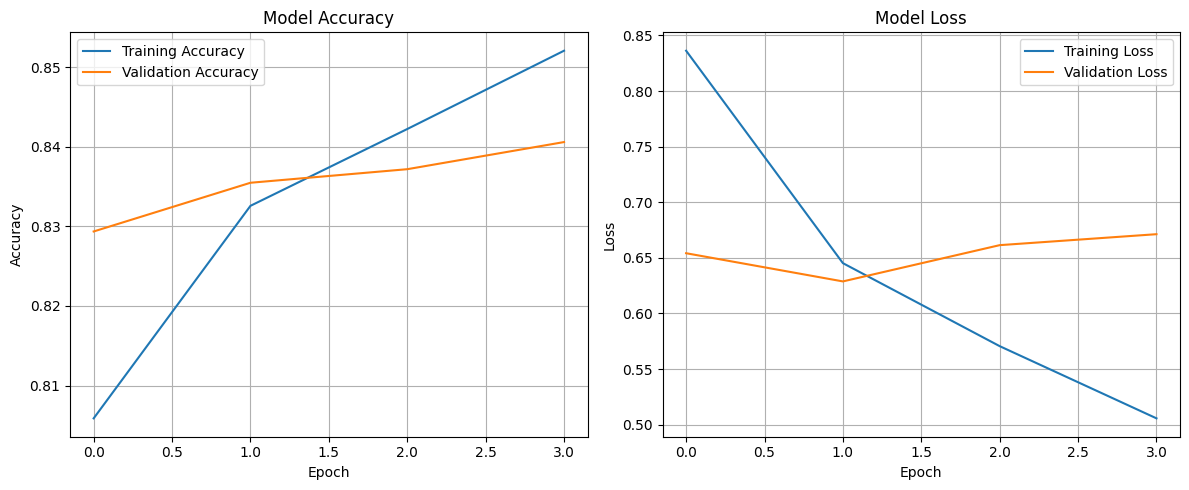

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Comparision of all the Deep Learning Models

In [40]:
import pandas as pd

# Create a dictionary to hold the metrics for each model
metrics_comparison = {
    'Metric': ['Product Precision', 'Product Recall', 'Product F1-score',
               'Sub-product Precision', 'Sub-product Recall', 'Sub-product F1-score',
               'Hierarchical Precision', 'Hierarchical Recall', 'Hierarchical F1-score'],
    'LSTM Model': [
        metrics['product_precision'], metrics['product_recall'], metrics['product_f1'],
        metrics['sub_product_precision'], metrics['sub_product_recall'], metrics['sub_product_f1'],
        metrics['hierarchical_precision'], metrics['hierarchical_recall'], metrics['hierarchical_f1']
    ],
    'Bidirectional LSTM Model': [
        bi_lstm_metrics['product_precision'], bi_lstm_metrics['product_recall'], bi_lstm_metrics['product_f1'],
        bi_lstm_metrics['sub_product_precision'], bi_lstm_metrics['sub_product_recall'], bi_lstm_metrics['sub_product_f1'],
        bi_lstm_metrics['hierarchical_precision'], bi_lstm_metrics['hierarchical_recall'], bi_lstm_metrics['hierarchical_f1']
    ],
    'Stacked LSTM Model': [
        stklstm_metrics['product_precision'], stklstm_metrics['product_recall'], stklstm_metrics['product_f1'],
        stklstm_metrics['sub_product_precision'], stklstm_metrics['sub_product_recall'], stklstm_metrics['sub_product_f1'],
        stklstm_metrics['hierarchical_precision'], stklstm_metrics['hierarchical_recall'], stklstm_metrics['hierarchical_f1']
    ],
    'CNN-1D Model': [
        cnn_metrics['product_precision'], cnn_metrics['product_recall'], cnn_metrics['product_f1'],
        cnn_metrics['sub_product_precision'], cnn_metrics['sub_product_recall'], cnn_metrics['sub_product_f1'],
        cnn_metrics['hierarchical_precision'], cnn_metrics['hierarchical_recall'], cnn_metrics['hierarchical_f1']
    ]

}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_comparison)

# Display the comparison table
display(metrics_df)

,Metric,LSTM Model,Bidirectional LSTM Model,Stacked LSTM Model,CNN-1D Model
0,Product Precision,0.879773,0.886735,0.862177,0.845743
1,Product Recall,0.890059,0.890802,0.882595,0.859740
2,Product F1-score,0.877123,0.877244,0.865855,0.829963
3,Sub-product Precision,0.836466,0.845372,0.800357,0.791131
4,Sub-product Recall,0.866089,0.868907,0.853980,0.848993
5,Sub-product F1-score,0.846696,0.850017,0.824657,0.809085
6,Hierarchical Precision,0.858120,0.866054,0.831267,0.818437
7,Hierarchical Recall,0.878074,0.879854,0.868287,0.854367
8,Hierarchical F1-score,0.861910,0.863630,0.845256,0.819524
